In [29]:
# Manipulación de datos
import pandas as pd
import numpy as np
import json
import random
import math

# Manipulación NLP
import re

# Otras librerias
import warnings
import glob
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#warnings.simplefilter("ignore", UserWarning)

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, learning_curve, validation_curve, GridSearchCV
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Grafico de datos
import seaborn as sns
import matplotlib.pyplot as plt

#Manejo de fechas
from datetime import datetime
import holidays
#Manejo de datos
import sqlite3

#Exportar el modelo
import joblib

## Acceso al DWH

In [3]:
# Establecer la conexión a la base de datos SQLite (si no existe, se creará automáticamente)
conn_ml = sqlite3.connect('../data/rose_ml.db')

In [60]:
consulta_sql = "SELECT * FROM dwh_remedy_tickets_flm"
df_dwh = pd.read_sql_query(consulta_sql, conn_ml)

df_dwh.head(5)

,creation_date,closed_date,Product_Categorization_Tier_1,Product_Categorization_Tier_2,Product_Categorization_Tier_3,Categorization_Tier_1,Categorization_Tier_2,Categorization_Tier_3,domain_name,Notas,...,EBC,URA,NODAL,GE_OPERA,BAJO_VOLTAJE_BATERIAS,departamento_flm,provincia_flm,distrito_flm,con_corte_prog,contencion
0,2021-10-04 14:57:32,2021-10-04 17:18:34,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ACCESO MOVIL,Prioridad: PLATA\nMasiva: NO\nGestor: ERICSSON...,...,1,0,1,0,0,LA LIBERTAD,TRUJILLO,HUANCHACO,0,1
1,2021-10-04 18:49:59,2021-10-05 01:07:53,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ACCESO MOVIL,Prioridad: PLATA\nMasiva: NO\nGestor: ERICSSON...,...,1,0,1,0,0,CAJAMARCA,JAEN,JAEN,0,0
2,2021-10-05 06:17:34,2021-10-06 19:54:45,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ENERGIA,INC000007750671\n\nSIOM=65181\n\nURA VIRU / TR...,...,1,1,0,0,0,LA LIBERTAD,VIRU,VIRU,0,0
3,2021-10-05 12:57:03,2021-10-06 06:02:11,ENERGIA,DC,BANCO DE BATERIAS,ENERGIA,FALLA DE ENERGIA DC -TDP,FALLA BATERÍAS,ENERGIA,Prioridad: ORO\nMasiva: NO\nGestor: ERICSSON E...,...,1,0,0,0,1,PIURA,PIURA,PIURA,0,0
4,2021-10-05 13:03:49,2021-10-05 21:01:35,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ACCESO MOVIL,Prioridad: ORO\nMasiva: NO\nGestor: ERICSSON E...,...,1,0,0,0,0,CUSCO,CUSCO,CUSCO,0,1


## Selección de caracteristicas

In [5]:
df_dwh.columns

Index(['creation_date', 'closed_date', 'Product_Categorization_Tier_1',
       'Product_Categorization_Tier_2', 'Product_Categorization_Tier_3',
       'Categorization_Tier_1', 'Categorization_Tier_2',
       'Categorization_Tier_3', 'domain_name', 'Notas', 'Protocolo',
       'duracion_hrs', 'duracion_class', 'prioridad', 'gestor', 'alarma',
       'departamento_ticket', 'elemento', 'nombre_elemento',
       'descripcion_alarma', 'id_sitio', 'tecnologia', 'ml_alarm',
       'alarma_clean', 'weekday', 'daytype', 'holiday', 'shift', 'year',
       'month', 'day', 'hour', 'EBC', 'URA', 'NODAL', 'GE_OPERA',
       'BAJO_VOLTAJE_BATERIAS', 'departamento_flm', 'provincia_flm',
       'distrito_flm', 'con_corte_prog', 'contencion'],
      dtype='object')

In [61]:
df_selected = df_dwh[['month', 'day', 'hour', 'Product_Categorization_Tier_1', 'Product_Categorization_Tier_2', 'Product_Categorization_Tier_3', 'Categorization_Tier_1', 'Categorization_Tier_2', 'Categorization_Tier_3', 'domain_name', 'prioridad', 'gestor', 'alarma', 'id_sitio', 'tecnologia', 'weekday', 'daytype', 'holiday', 'shift', 'EBC', 'URA', 'NODAL', 'GE_OPERA', 'departamento_flm', 'provincia_flm', 'distrito_flm', 'con_corte_prog', 'contencion']]

In [62]:
df_selected.head(5)

,month,day,hour,Product_Categorization_Tier_1,Product_Categorization_Tier_2,Product_Categorization_Tier_3,Categorization_Tier_1,Categorization_Tier_2,Categorization_Tier_3,domain_name,...,shift,EBC,URA,NODAL,GE_OPERA,departamento_flm,provincia_flm,distrito_flm,con_corte_prog,contencion
0,10,4,14,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ACCESO MOVIL,...,Day,1,0,1,0,LA LIBERTAD,TRUJILLO,HUANCHACO,0,1
1,10,4,18,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ACCESO MOVIL,...,Day,1,0,1,0,CAJAMARCA,JAEN,JAEN,0,0
2,10,5,6,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ENERGIA,...,Day,1,1,0,0,LA LIBERTAD,VIRU,VIRU,0,0
3,10,5,12,ENERGIA,DC,BANCO DE BATERIAS,ENERGIA,FALLA DE ENERGIA DC -TDP,FALLA BATERÍAS,ENERGIA,...,Day,1,0,0,0,PIURA,PIURA,PIURA,0,0
4,10,5,13,ENERGIA,AC,ACOMETIDA ELECTRICA,ENERGIA,FALLA DE ENERGIA AC -TDP,FALLA DE LÍNEA BT,ACCESO MOVIL,...,Day,1,0,0,0,CUSCO,CUSCO,CUSCO,0,1


In [8]:
#Exploración de los datos
#df_selected['con_corte_prog'].value_counts()

In [63]:
len(df_selected.columns)

28

In [64]:
df_selected.dtypes

month                             int64
day                               int64
hour                              int64
Product_Categorization_Tier_1    object
Product_Categorization_Tier_2    object
Product_Categorization_Tier_3    object
Categorization_Tier_1            object
Categorization_Tier_2            object
Categorization_Tier_3            object
domain_name                      object
prioridad                        object
gestor                           object
alarma                           object
id_sitio                         object
tecnologia                       object
weekday                           int64
daytype                          object
holiday                           int64
shift                            object
EBC                               int64
URA                               int64
NODAL                             int64
GE_OPERA                          int64
departamento_flm                 object
provincia_flm                    object


In [65]:
#Separamos las variables numericas de las categoricas
numeric_features = list(df_selected.select_dtypes(exclude=['object']))
categorical_features = list(df_selected.select_dtypes(include=['object']))

In [66]:
df_selected.select_dtypes(exclude=['object'])

,month,day,hour,weekday,holiday,EBC,URA,NODAL,GE_OPERA,con_corte_prog,contencion
0,10,4,14,0,0,1,0,1,0,0,1
1,10,4,18,0,0,1,0,1,0,0,0
2,10,5,6,1,0,1,1,0,0,0,0
3,10,5,12,1,0,1,0,0,0,0,0
4,10,5,13,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
16229,1,1,11,6,1,1,0,1,0,1,1
16230,1,1,13,6,1,1,0,0,0,1,0
16231,1,1,18,6,1,1,0,1,0,1,1
16232,1,1,18,6,1,1,0,0,0,0,1


In [67]:
numeric_features.remove('contencion')

In [68]:
numeric_features

['month',
 'day',
 'hour',
 'weekday',
 'holiday',
 'EBC',
 'URA',
 'NODAL',
 'GE_OPERA',
 'con_corte_prog']

In [69]:
categorical_features

['Product_Categorization_Tier_1',
 'Product_Categorization_Tier_2',
 'Product_Categorization_Tier_3',
 'Categorization_Tier_1',
 'Categorization_Tier_2',
 'Categorization_Tier_3',
 'domain_name',
 'prioridad',
 'gestor',
 'alarma',
 'id_sitio',
 'tecnologia',
 'daytype',
 'shift',
 'departamento_flm',
 'provincia_flm',
 'distrito_flm']

In [70]:
#Seperamos nuestro dataframe en los datos que vamos a extraer
x = df_selected[categorical_features + numeric_features]
y = df_selected['contencion']

In [71]:
#Dividimos nuestros datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=7)


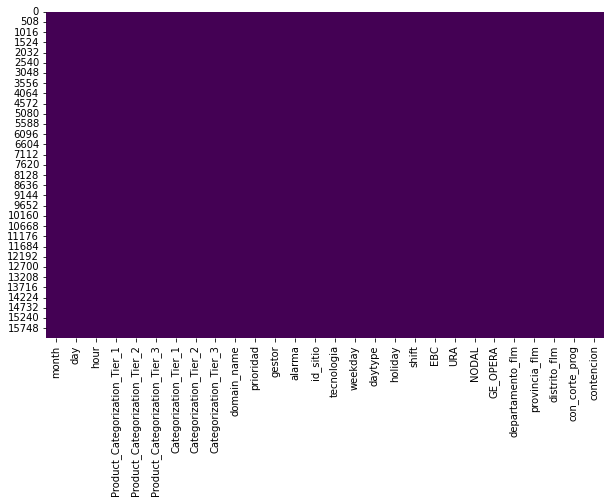

In [72]:
#Verificando datos nulos
plt.figure(figsize=(10, 6))
sns.heatmap(df_selected.isnull(), cmap='viridis', cbar=False)
plt.show()

In [73]:
# Obtenemos la informacion de las variables numericas
df_selected[numeric_features].describe()

,month,day,hour,weekday,holiday,EBC,URA,NODAL,GE_OPERA,con_corte_prog
count,16234.000000,16234.000000,16234.000000,16234.000000,16234.000000,16234.0,16234.000000,16234.000000,16234.000000,16234.000000
mean,6.965258,15.789577,11.708205,3.059074,0.036343,1.0,0.091351,0.490144,0.046692,0.504990
std,3.814626,8.627814,5.715027,2.001760,0.187149,0.0,0.288117,0.499918,0.210985,0.499991
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,7.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
50%,7.000000,16.000000,12.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000
75%,11.000000,23.000000,16.000000,5.000000,0.000000,1.0,0.000000,1.000000,0.000000,1.000000
max,12.000000,31.000000,23.000000,6.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


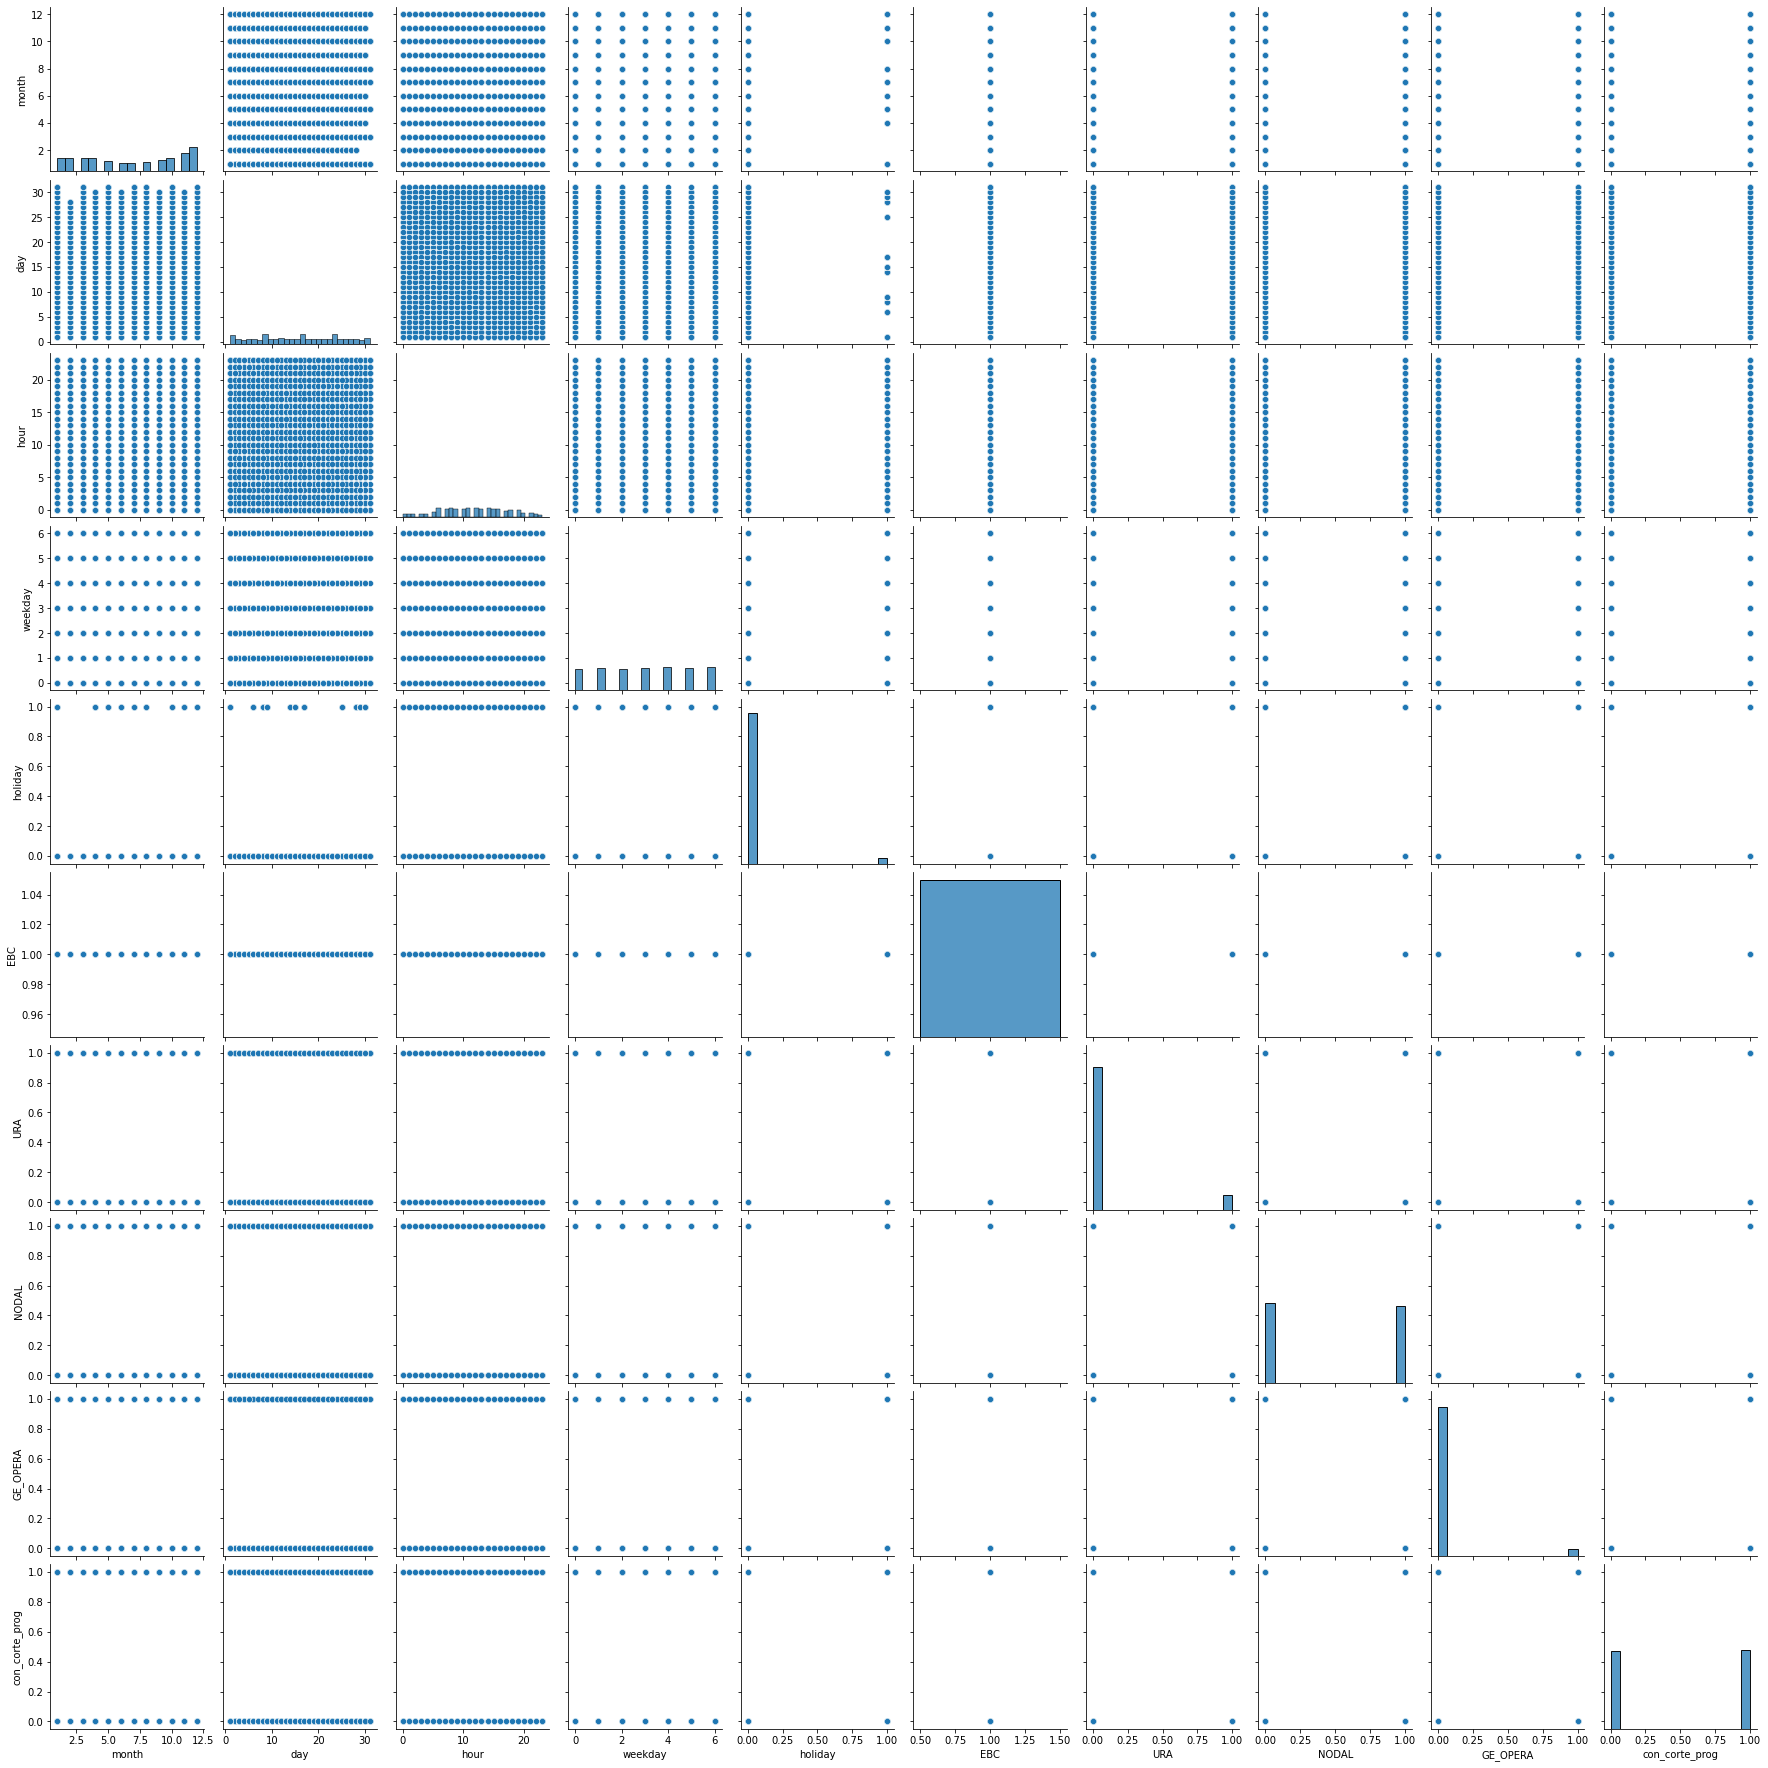

In [74]:
# Se observa la distribución y escala de los datos
sns.pairplot(df_selected[numeric_features])

In [77]:
# Se crea el pipeline para los datos categoricos
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
# Se crea el pipeline para los datos numericos
numeric_transformer = Pipeline(steps=[('minmax', StandardScaler())])
# Se integran los pipelines anteriores y se especifica que las columnas no declaradas en categorical_featues y numeric_features también se conserven
columnasTransformer = ColumnTransformer(
    transformers = [
        ('categorical_data_pre', categorical_transformer, categorical_features),
        ('numeric_data_pre', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

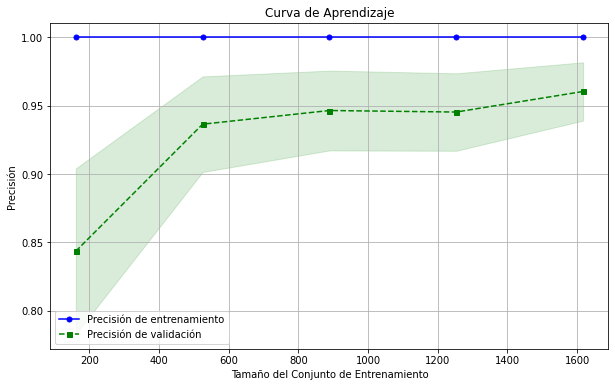

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_digits
from sklearn.svm import SVC

# Cargamos un conjunto de datos de ejemplo (puedes usar tus propios datos)
X, y = load_digits(return_X_y=True)

# Define el modelo que deseas evaluar
model = SVC(kernel='linear')

# Genera las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=10, scoring='accuracy', n_jobs=-1)

# Calcula las medias y desviaciones estándar de las puntuaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Grafica las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Precisión de entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Precisión de validación')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Curva de Aprendizaje')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Precisión')
plt.legend(loc='best')
plt.grid()
plt.show()


In [30]:
# Se definen las formulas para evaluar el desempeño del modelo
def mi_recall(yreal, ypred):
    vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
    recall = vp / (vp+fn)
    return recall

def my_accuracy(yreal, ypred):
    tn, fp, fn, tp = confusion_matrix(yreal, ypred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy

def my_f1_score(yreal, ypred):
    tn, fp, fn, tp = confusion_matrix(yreal, ypred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1
def my_precision(yreal, ypred):
    tn, fp, fn, tp = confusion_matrix(yreal, ypred).ravel()
    precision = tp / (tp + fp)
    return precision

def mi_gmean(yreal, ypred):
    vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
    recall = vp / (vp+fn)
    especificidad = vn / (vn+fp)
    gmean = np.sqrt(recall * especificidad)
    return gmean

In [50]:
#Función para graficar la grafica de aprendizaje
def my_LearningCurvePlot(train_sizes, train_scores, val_scores, scorer_name, curve_name):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    #plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.title(curve_name)
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel(scorer_name)
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [49]:
def my_ValidationCurvePlot(train_scores, valid_scores, delta_C, scorer_name, curve_name, msg):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)


    # Curva de entrenamiento con la métrica de exactitud (accuracy):
    plt.plot(delta_C, train_mean, color='blue', marker='o', markersize=5, label='Training')

    # Curva de validación:
    plt.plot(delta_C, valid_mean, color='red', marker='o', markersize=5, label='Validation')

    #plt.title('Función validation_curve()')
    plt.title(curve_name)
    plt.xlabel(msg)
    plt.ylabel(scorer_name)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

In [51]:
#Función para definir 3 modelos a evaluar
#LogisticRegression
#DecisionTreeClassifier
#RandomForestClassifier 
def get_models():
    """
    El objetivo de esta funcion es regresar dos listas con los modelos y nombre de cada uno
    return models, nombres
    """
    models = list()
    nombres = list()
    params = list()
    
    models.append(LogisticRegression(max_iter=10000))
    nombres.append('Regresion Log')
    params.append({
        'model__max_iter': [10000],
        'model__C':[0.001, 0.01, 0.1, 1, 10],
        'model__solver':['newton-cg','lbfgs','liblinear','sag','saga'],
        'model__class_weight':['balanced'],
        'model__penalty':['l2']
    })
    
    models.append(DecisionTreeClassifier())
    nombres.append('DT')
    params.append({
        'model__ccp_alpha': [0.001, 0.01, 0.1, 1, 10],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [10,20,30],
        'model__min_samples_split': [2],
        'model__class_weight': ['balanced']
    })
    
    models.append(RandomForestClassifier())
    nombres.append('RF')
    params.append({
        'model__ccp_alpha': [0.001, 0.01, 0.1, 1, 10],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [10,20,30],
        'model__min_samples_split': [2],
        'model__class_weight': ['balanced'],
        'model__n_jobs': [-1]
    })
    
    return models, nombres, params

In [54]:
# Se obtienen los modelos a entrenar
models, nombres, params = get_models()  
resultados = list()
scorer = [make_scorer(my_f1_score),make_scorer(my_f1_score),make_scorer(my_f1_score)]
scorer_name = ['f1-score','f1-score','f1-score']

for i in range(len(models)):
    print("Fecha de inicio de modelo: ", datetime.now())
    print("==============")
    print(nombres[i])
    print("==============")
    # Se define el pipeline de procesamiento y con el modelo que se vaya a entrenar
    pipe = Pipeline([('pre-process', columnasTransformer), ('model', models[i])])
    # Se declara el numero de particiones y repeticiones de los kfold
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    # Se definen las metricas de desempeño para la validación cruzada
    mismetricas = {
        'accuracy':make_scorer(accuracy_score),
        'precision':make_scorer(precision_score),
        'gmean':make_scorer(mi_gmean),
        'recall':make_scorer(recall_score),
        'f1-score':make_scorer(f1_score)
    }
    # Se usa la funcion cross validate para obtener las metricas de desemepo en los conjuntos de entrenamiento y validación
    resultadosOU = cross_validate(pipe,x_train,y_train,cv=cv, n_jobs=-1, scoring = mismetricas, return_train_score=True)
    resultados.append(resultadosOU)
    # Se despliegan las metricas de desempeño
    print('train mean Accuracy: %.3f (%.4f)\ntrain mean Recall: %.3f (%.4f)\ntrain Gmean: %.3f (%.4f)\ntrain Precision: %.3f (%.4f)\ntrain f1-score: %.3f (%.4f)\nvalidation mean Accuracy: %.3f (%.4f)\nvalidation mean Recall: %.3f (%.4f)\nvalidation Gmean: %.3f (%.4f)\nvalidation Precision: %.3f (%.4f)\nvalidation f1-score: %.3f (%.4f)\n' % (
        np.mean(resultadosOU['train_accuracy']),
        np.std(resultadosOU['train_accuracy']), 
        np.mean(resultadosOU['train_recall']),
        np.std(resultadosOU['train_recall']),
        np.mean(resultadosOU['train_gmean']),
        np.std(resultadosOU['train_gmean']), 
        np.mean(resultadosOU['train_precision']),
        np.std(resultadosOU['train_precision']),
        np.mean(resultadosOU['train_f1-score']),
        np.std(resultadosOU['train_f1-score']),
        np.mean(resultadosOU['test_accuracy']),
        np.std(resultadosOU['test_accuracy']), 
        np.mean(resultadosOU['test_recall']),
        np.std(resultadosOU['test_recall']),
        np.mean(resultadosOU['test_gmean']),
        np.std(resultadosOU['test_gmean']), 
        np.mean(resultadosOU['test_precision']),
        np.std(resultadosOU['test_precision']),
        np.mean(resultadosOU['test_f1-score']),
        np.std(resultadosOU['test_f1-score'])
    ))
    
    delta_train_sz = np.linspace(0.1, 1, num=20)
    #if nombres[i] != 'DT':
    #    tr_sizes, tr_scores, val_scores = learning_curve(estimator = pipe ,    
    #                                                        X = x_train,
    #                                                        y = np.ravel(y_train),
    #                                                        cv = cv ,
    #                                                        scoring=scorer[i],
    #                                                        train_sizes = delta_train_sz,
    #                                                        random_state=1
    #                                                    )
    #    my_LearningCurvePlot(tr_sizes, tr_scores, val_scores,scorer_name[i], 'Curva de aprendizaje (Learning Curve) ' + nombres[i])
    #else:
    #    delta = [v for v in range(1, 21)]
    #    train_scores, valid_scores = validation_curve(pipe, x_train, y_train, cv=cv, param_name="model__max_depth", param_range=delta)
    #    my_LearningCurvePlot(train_scores, valid_scores, delta, scorer_name[i], 'Curva de validación (Validation Curve) ' + nombres[i], 'Profundidad del arbol')

Fecha de inicio de modelo:  2023-10-05 23:36:10.759515
Regresion Log
train mean Accuracy: 0.879 (0.0040)
train mean Recall: 0.952 (0.0028)
train Gmean: 0.835 (0.0057)
train Precision: 0.878 (0.0039)
train f1-score: 0.914 (0.0028)
validation mean Accuracy: 0.740 (0.0226)
validation mean Recall: 0.853 (0.0222)
validation Gmean: 0.660 (0.0334)
validation Precision: 0.780 (0.0184)
validation f1-score: 0.814 (0.0164)

Fecha de inicio de modelo:  2023-10-05 23:36:15.385054
DT
train mean Accuracy: 1.000 (0.0000)
train mean Recall: 1.000 (0.0000)
train Gmean: 1.000 (0.0000)
train Precision: 1.000 (0.0000)
train f1-score: 1.000 (0.0000)
validation mean Accuracy: 0.697 (0.0175)
validation mean Recall: 0.794 (0.0226)
validation Gmean: 0.630 (0.0333)
validation Precision: 0.764 (0.0183)
validation f1-score: 0.778 (0.0126)

Fecha de inicio de modelo:  2023-10-05 23:36:17.627270
RF
train mean Accuracy: 1.000 (0.0002)
train mean Recall: 1.000 (0.0000)
train Gmean: 1.000 (0.0003)
train Precision: 1.00

Se concluye un sobreentrenamiento sobre los modelos RandomForest y DecisionTree

El modelo con mejor desempeño es el **LogisticRegression**

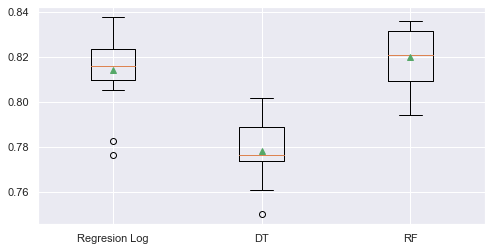

In [80]:
# Se muestra en desempeño de los tres modelos que se implementaron
sns.set(rc={'figure.figsize':(8,4)})

bpGmean = list()
for i in range(len(resultados)):
    rr = resultados[i]['test_f1-score']
    bpGmean.append(rr)

plt.boxplot(bpGmean, labels=nombres, showmeans=True)

plt.show()

In [81]:
def get_pipeline(model) -> Pipeline:
    return Pipeline([('pre-process', columnasTransformer), ('model', model)])
def do_grid_search(model, nombre, dicc_grid, metric):

    grid_pipe = get_pipeline(model)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

    grid = GridSearchCV(
        estimator= grid_pipe, cv=cv, 
        param_grid=dicc_grid, scoring=metric)

    #Xx = columnasTransformer.fit_transform(Xtv)
    
    grid.fit(x_train, y_train.values.ravel())
    
    print(nombre)
    print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
    print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
    print(f'Métrica utilizada: {grid.scoring}\n')
    
    return grid.best_score_, grid.best_params_, {grid.scoring}


In [82]:
print("Fecha de inicio de ejecución: ", datetime.now())

Fecha de inicio de ejecución:  2023-10-05 23:41:53.275667


In [ ]:
metric = [make_scorer(f1_score), make_scorer(f1_score), make_scorer(f1_score) ]
best_params = list()
for i in range(len(models)):
    print("Fecha de inicio de modelo: ", datetime.now())
    print("Modelo: ", nombres[i])
    b_score, b_params, b_scoring = do_grid_search(models[i], nombres[i], params[i], metric[i])
    best_params.append(b_params)
    pipe = get_pipeline(models[i])
    pipe.set_params(**b_params)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    
    delta_train_sz = np.linspace(0.1, 1, num=20)
    #if nombres[i] != 'RF':
    #tr_sizes, tr_scores, val_scores = learning_curve(estimator = pipe ,    
    #                                                    X = x_train,
    #                                                    y = np.ravel(y_train),
    #                                                    cv = cv ,
    #                                                    scoring=metric[i],
    #                                                    train_sizes = delta_train_sz,
    #                                                    random_state=1
    #                                                )
    #my_LearningCurvePlot(tr_sizes, tr_scores, val_scores,metric[i], 'Curva de aprendizaje (Learning Curve) ' + nombres[i])
    #else:
    #    delta = [v for v in range(1, 21)]
    #    train_scores, valid_scores = validation_curve(pipe, x_train, np.ravel(y_train), cv=cv, param_name="model__max_depth", param_range=delta)
    #    my_ValidationCurvePlot(train_scores, valid_scores, delta, scorer_name[i], 'Curva de validación (Validation Curve) ' + nombres[i], 'Profundidad del arbol')


Fecha de inicio de modelo:  2023-10-05 23:43:26.267295
Modelo:  Regresion Log


In [ ]:
print("Fecha de fin de ejecución: ", datetime.now())

In [36]:
best_params = []
#LogisticRegression
best_params.append({'model__C': 20, 'model__class_weight': 'balanced', 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__solver': 'lbfgs'})
best_params.append({'model__ccp_alpha': 0.0, 'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 12, 'model__min_samples_split': 2})
best_params.append({'model__ccp_alpha': 0.0, 'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_jobs': -1})

Fecha de inicio de modelo:  2023-08-09 03:29:17.931701
Regresion Log
recall del mejor modelo en el conjunto de entrenamiento 82.27%
recall del mejor modelo en el conjunto de prueba 74.88% 

Fecha de inicio learning curve:  2023-08-09 03:29:37.819207


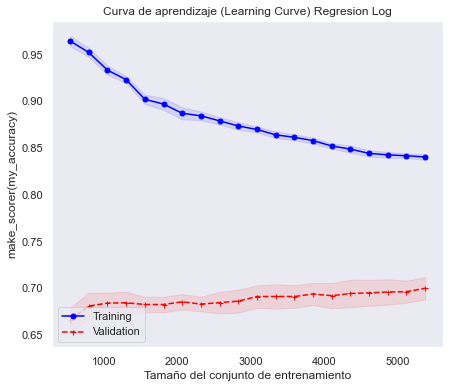

Fecha de fin learning curve:  2023-08-09 03:58:32.306712


D:\System_Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


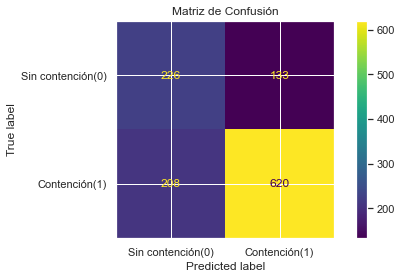

Fecha de fin de modelo:  2023-08-09 03:58:32.551579
Fecha de inicio de modelo:  2023-08-09 03:58:32.551579
DT
recall del mejor modelo en el conjunto de entrenamiento 96.27%
recall del mejor modelo en el conjunto de prueba 91.06% 

Fecha de inicio learning curve:  2023-08-09 03:58:36.206383


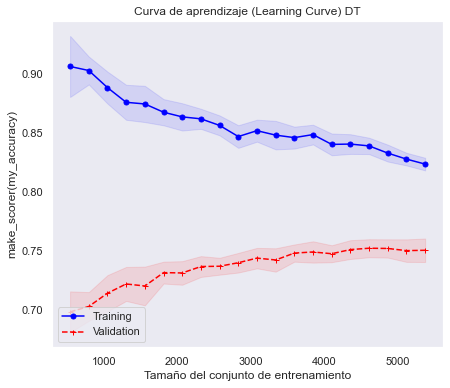

Fecha de fin learning curve:  2023-08-09 04:03:58.497943


D:\System_Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


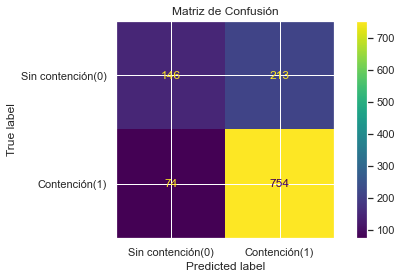

Fecha de fin de modelo:  2023-08-09 04:03:58.977014
Fecha de inicio de modelo:  2023-08-09 04:03:58.977014
RF
recall del mejor modelo en el conjunto de entrenamiento 99.74%
recall del mejor modelo en el conjunto de prueba 99.28% 

Fecha de inicio learning curve:  2023-08-09 04:04:01.469071


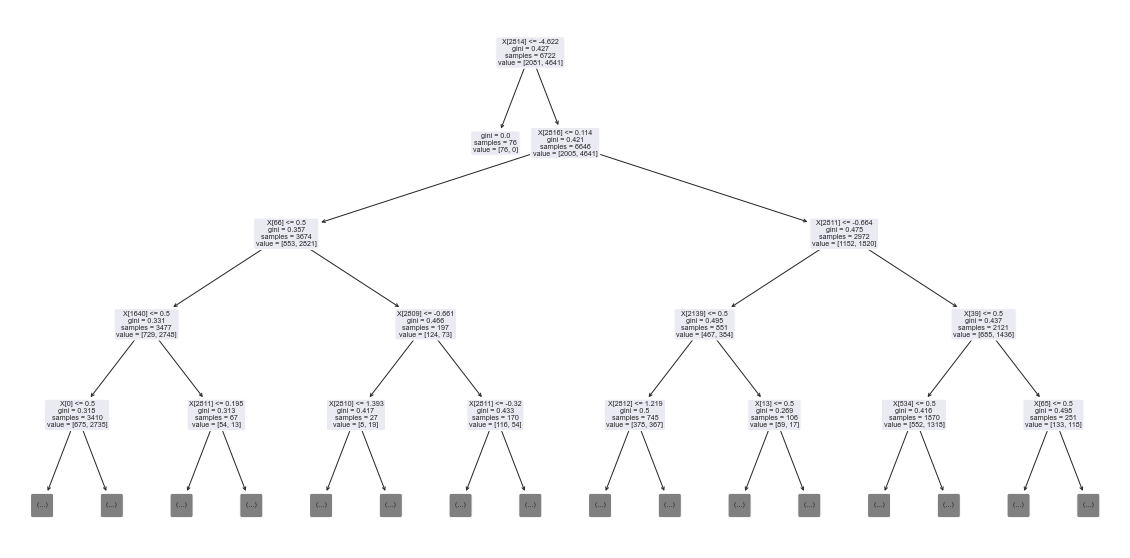

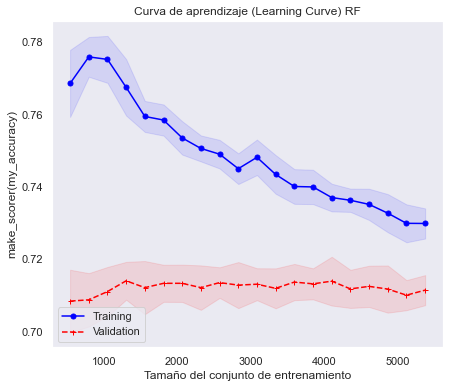

Fecha de fin learning curve:  2023-08-09 04:11:07.873292


D:\System_Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


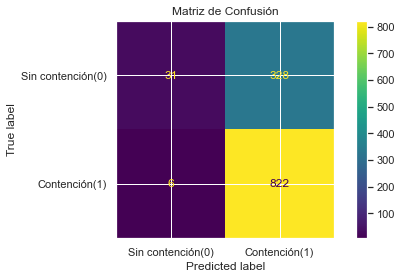

Fecha de fin de modelo:  2023-08-09 04:11:08.167397


In [31]:
metrics = [mi_recall, mi_recall, mi_recall]
#metric_names = ['f1-score', 'precision', 'recall']
metric_names = ['recall', 'recall', 'recall']
for i in range(len(models)):
    print("Fecha de inicio de modelo: ", datetime.now())
    pipe = get_pipeline(models[i])
    pipe.set_params(**best_params[i])
    pipe.fit(x_train, np.ravel(y_train))
    print(nombres[i])
    print(f'{metric_names[i]} del mejor modelo en el conjunto de entrenamiento {round(100*metrics[i](y_train, pipe.predict(x_train)), 2)}%')
    print(f'{metric_names[i]} del mejor modelo en el conjunto de prueba {round(100*metrics[i](y_test, pipe.predict(x_test)), 2)}% \n')
    
    # Grafica la matriz de confusión
    print("Fecha de inicio learning curve: ", datetime.now())
    delta_train_sz = np.linspace(0.1, 1, num=20)
    tr_sizes, tr_scores, val_scores = learning_curve(estimator = pipe ,    
                                                        X = x_train,
                                                        y = np.ravel(y_train),
                                                        cv = cv ,
                                                        scoring=metric[i],
                                                        train_sizes = delta_train_sz,
                                                        random_state=1
                                                    )
    my_LearningCurvePlot(tr_sizes, tr_scores, val_scores,metric[i], 'Curva de aprendizaje (Learning Curve) ' + nombres[i] )
    print("Fecha de fin learning curve: ", datetime.now())
    plot_confusion_matrix(pipe, x_test, y_test, display_labels=['Sin contención(0)', 'Contención(1)'])
    plt.title("Matriz de Confusión")
    plt.show()
    if nombres[i] == 'DT':
        dot_data = tree.export_graphviz(decision_tree=pipe['model'], 
                                out_file=None,
                                max_depth=None,
                                filled=True,
                                rotate=True,
                                proportion=False)
        plt.subplots(figsize=(20,10))
        tree.plot_tree(pipe['model'], max_depth=4, rounded=True)
    print("Fecha de fin de modelo: ", datetime.now())
    

Fecha de inicio de modelo:  2023-08-09 04:11:08.193456
Regresion Log
f1-score del mejor modelo en el conjunto de entrenamiento 86.92%
f1-score del mejor modelo en el conjunto de prueba 78.43% 

Fecha de inicio learning curve:  2023-08-09 04:11:27.718331


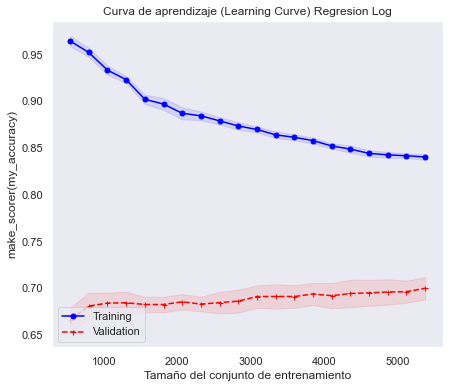

Fecha de fin learning curve:  2023-08-09 04:40:07.230665


D:\System_Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


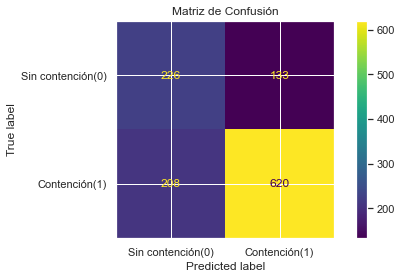

Fecha de fin de modelo:  2023-08-09 04:40:07.490943
Fecha de inicio de modelo:  2023-08-09 04:40:07.490943
DT
f1-score del mejor modelo en el conjunto de entrenamiento 87.96%
f1-score del mejor modelo en el conjunto de prueba 84.26% 

Fecha de inicio learning curve:  2023-08-09 04:40:11.194578


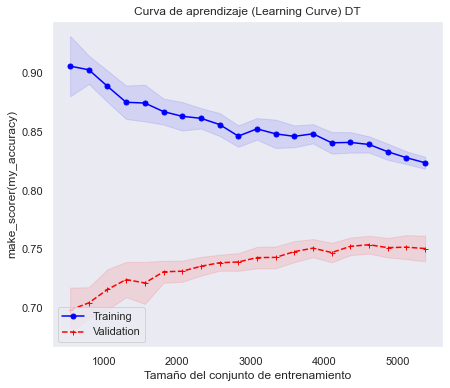

Fecha de fin learning curve:  2023-08-09 04:45:33.483219


D:\System_Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


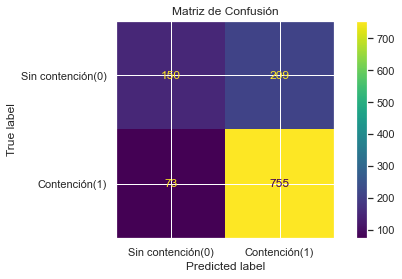

Fecha de fin de modelo:  2023-08-09 04:45:33.971672
Fecha de inicio de modelo:  2023-08-09 04:45:33.971672
RF
f1-score del mejor modelo en el conjunto de entrenamiento 83.41%
f1-score del mejor modelo en el conjunto de prueba 83.06% 

Fecha de inicio learning curve:  2023-08-09 04:45:36.445836


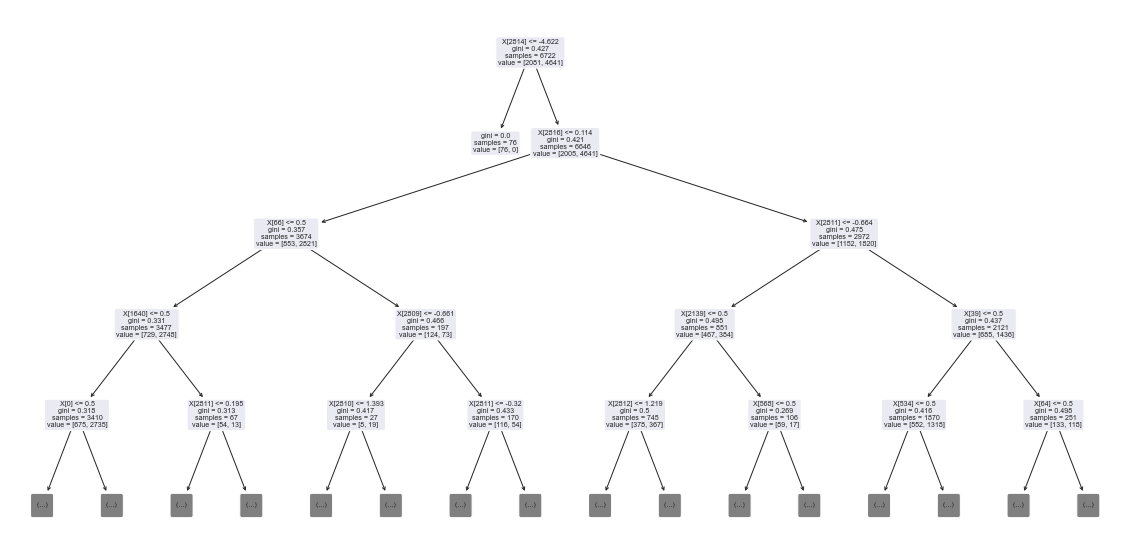

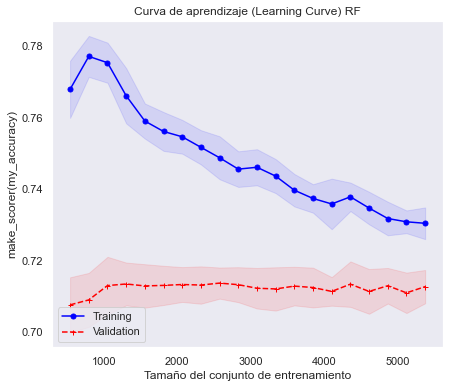

Fecha de fin learning curve:  2023-08-09 04:52:48.674526


D:\System_Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


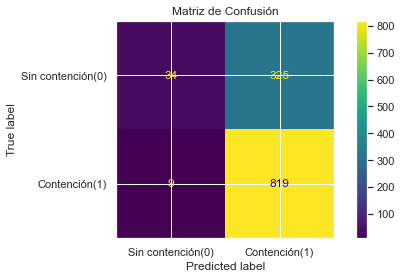

Fecha de fin de modelo:  2023-08-09 04:52:48.953416


In [32]:
metrics = [my_f1_score, my_f1_score, my_f1_score]
#metric_names = ['f1-score', 'precision', 'recall']
metric_names = ['f1-score', 'f1-score', 'f1-score']
for i in range(len(models)):
    print("Fecha de inicio de modelo: ", datetime.now())
    pipe = get_pipeline(models[i])
    pipe.set_params(**best_params[i])
    pipe.fit(x_train, np.ravel(y_train))
    print(nombres[i])
    print(f'{metric_names[i]} del mejor modelo en el conjunto de entrenamiento {round(100*metrics[i](y_train, pipe.predict(x_train)), 2)}%')
    print(f'{metric_names[i]} del mejor modelo en el conjunto de prueba {round(100*metrics[i](y_test, pipe.predict(x_test)), 2)}% \n')
    
    # Grafica la matriz de confusión
    print("Fecha de inicio learning curve: ", datetime.now())
    delta_train_sz = np.linspace(0.1, 1, num=20)
    tr_sizes, tr_scores, val_scores = learning_curve(estimator = pipe ,    
                                                        X = x_train,
                                                        y = np.ravel(y_train),
                                                        cv = cv ,
                                                        scoring=metric[i],
                                                        train_sizes = delta_train_sz,
                                                        random_state=1
                                                    )
    my_LearningCurvePlot(tr_sizes, tr_scores, val_scores,metric[i], 'Curva de aprendizaje (Learning Curve) ' + nombres[i] )
    print("Fecha de fin learning curve: ", datetime.now())
    plot_confusion_matrix(pipe, x_test, y_test, display_labels=['Sin contención(0)', 'Contención(1)'])
    plt.title("Matriz de Confusión")
    plt.show()
    if nombres[i] == 'DT':
        dot_data = tree.export_graphviz(decision_tree=pipe['model'], 
                                out_file=None,
                                max_depth=None,
                                filled=True,
                                rotate=True,
                                proportion=False)
        plt.subplots(figsize=(20,10))
        tree.plot_tree(pipe['model'], max_depth=4, rounded=True)
    print("Fecha de fin de modelo: ", datetime.now())
    

Fecha de inicio de modelo:  2023-08-13 22:29:58.669859
Regresion Log
f1-score del mejor modelo en el conjunto de entrenamiento 87.69%
f1-score del mejor modelo en el conjunto de prueba 78.15% 



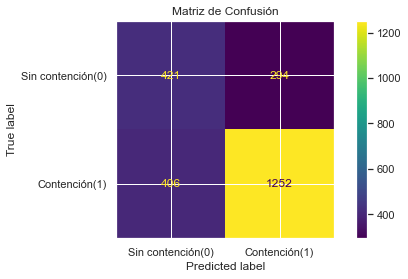

Fecha de fin de modelo:  2023-08-13 22:30:12.457299
Fecha de inicio de modelo:  2023-08-13 22:30:12.457299
DT
f1-score del mejor modelo en el conjunto de entrenamiento 87.92%
f1-score del mejor modelo en el conjunto de prueba 84.57% 



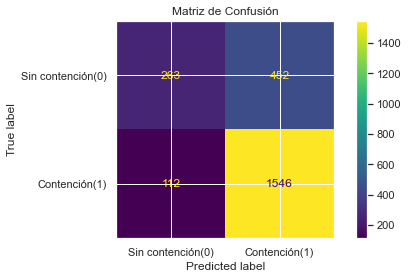

Fecha de fin de modelo:  2023-08-13 22:30:15.768026
Fecha de inicio de modelo:  2023-08-13 22:30:15.768026
RF
f1-score del mejor modelo en el conjunto de entrenamiento 83.37%
f1-score del mejor modelo en el conjunto de prueba 82.86% 



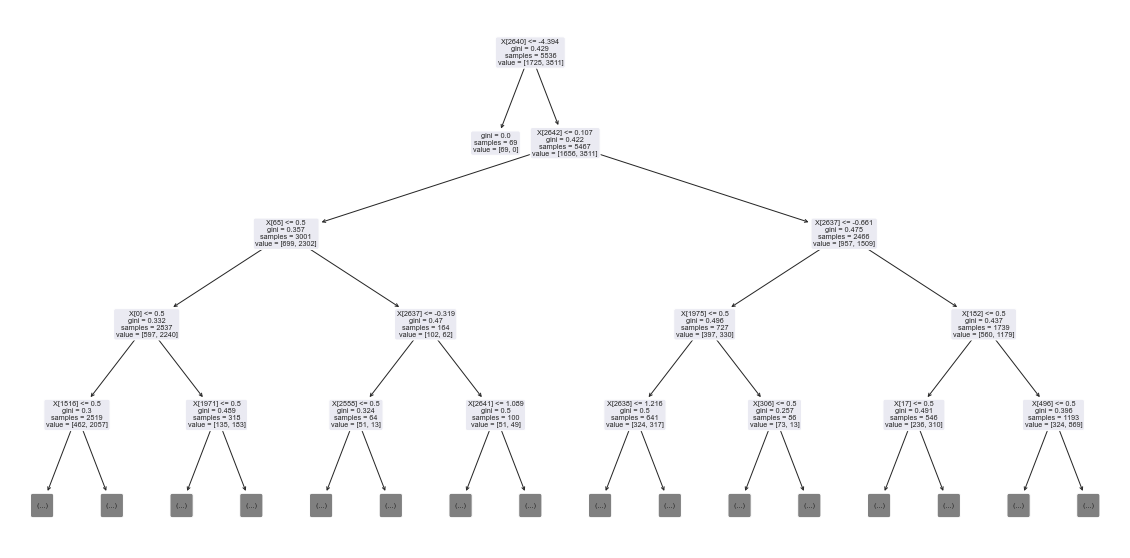

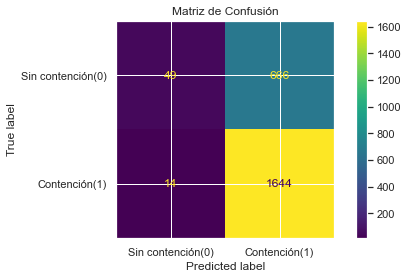

Fecha de fin de modelo:  2023-08-13 22:30:20.609663


In [37]:
metrics = [my_f1_score, my_f1_score, my_f1_score]
#metric_names = ['f1-score', 'precision', 'recall']
metric_names = ['f1-score', 'f1-score', 'f1-score']
t_models = []
for i in range(len(models)):
    print("Fecha de inicio de modelo: ", datetime.now())
    pipe = get_pipeline(models[i])
    pipe.set_params(**best_params[i])
    pipe.fit(x_train, np.ravel(y_train))
    t_models.append(pipe)
    print(nombres[i])
    print(f'{metric_names[i]} del mejor modelo en el conjunto de entrenamiento {round(100*metrics[i](y_train, pipe.predict(x_train)), 2)}%')
    print(f'{metric_names[i]} del mejor modelo en el conjunto de prueba {round(100*metrics[i](y_test, pipe.predict(x_test)), 2)}% \n')

    plot_confusion_matrix(pipe, x_test, y_test, display_labels=['Sin contención(0)', 'Contención(1)'])
    plt.title("Matriz de Confusión")
    plt.show()
    if nombres[i] == 'DT':
        dot_data = tree.export_graphviz(decision_tree=pipe['model'], 
                                out_file=None,
                                max_depth=None,
                                filled=True,
                                rotate=True,
                                proportion=False)
        plt.subplots(figsize=(20,10))
        tree.plot_tree(pipe['model'], max_depth=4, rounded=True)
    print("Fecha de fin de modelo: ", datetime.now())

In [132]:
predict_value = x_test.head(1)

In [109]:
type(predict_value)

pandas.core.frame.DataFrame

In [108]:
predict_value.shape

(1, 29)

In [103]:
predict_value.values

array([['ENERGIA', 'ESTACIONES BASE', 'LTE', 'ENERGIA',
        'FALLA DE ENERGIA AC -TDP', 'FALLA DE LÍNEA BT', 'ACCESO MOVIL',
        'Centinela_AM_NSN_3G_Genérico', 'masiva_1', 'PLATA',
        'NOKIA NETACT', 'FALLA RED AC', 'LI04060', '4G', 'Weekend',
        'Day', 'LIMA', 'LIMA', 'SAN MARTIN DE PORRES', 3, 25, 16, 5, 0,
        1, 0, 1, 0, 0]], dtype=object)

In [104]:
predict_value.columns

Index(['Product_Categorization_Tier_1', 'Product_Categorization_Tier_2',
       'Product_Categorization_Tier_3', 'Categorization_Tier_1',
       'Categorization_Tier_2', 'Categorization_Tier_3', 'domain_name',
       'sentinel_name', 'rule_name', 'prioridad', 'gestor', 'alarma',
       'id_sitio', 'tecnologia', 'daytype', 'shift', 'departamento_flm',
       'provincia_flm', 'distrito_flm', 'month', 'day', 'hour', 'weekday',
       'holiday', 'EBC', 'URA', 'NODAL', 'GE_OPERA', 'con_corte_prog'],
      dtype='object')

In [105]:
y_test.head(1)

3595    0
Name: contencion, dtype: int64

In [106]:
predict_value.values.tolist()

[['ENERGIA',
  'ESTACIONES BASE',
  'LTE',
  'ENERGIA',
  'FALLA DE ENERGIA AC -TDP',
  'FALLA DE LÍNEA BT',
  'ACCESO MOVIL',
  'Centinela_AM_NSN_3G_Genérico',
  'masiva_1',
  'PLATA',
  'NOKIA NETACT',
  'FALLA RED AC',
  'LI04060',
  '4G',
  'Weekend',
  'Day',
  'LIMA',
  'LIMA',
  'SAN MARTIN DE PORRES',
  3,
  25,
  16,
  5,
  0,
  1,
  0,
  1,
  0,
  0]]

In [110]:
result = t_models[2].predict(predict_value)

In [98]:
#t_models[2]

In [111]:
result

array([1], dtype=int64)

In [43]:
#Guardando modelo LogisticRegression
joblib.dump(t_models[0], '../models/ROSE_ML_Contencion_LogisticRegression_v1.0.1.pkl')

['../models/ROSE_ML_Contencion_LogisticRegression_v1.0.1.pkl']

In [44]:
#Guardando modelo LogisticRegression
joblib.dump(t_models[1], '../models/ROSE_ML_Contencion_DecisionTreeClassifierv1.0.1.pkl')

['../models/ROSE_ML_Contencion_DecisionTreeClassifierv1.0.1.pkl']

In [45]:
#Guardando modelo LogisticRegression
joblib.dump(t_models[2], '../models/ROSE_ML_Contencion_RandomForestClassifier_v1.0.1.pkl')

['../models/ROSE_ML_Contencion_RandomForestClassifier_v1.0.1.pkl']

In [119]:
modelo_cargado = joblib.load('../models/ROSE_ML_Contencion_LogisticRegression_v1.0.1.pkl')

In [120]:
modelo_cargado.predict(predict_value)

array([1], dtype=int64)

In [126]:
predict_value.values

array([['ENERGIA', 'ESTACIONES BASE', 'LTE', 'ENERGIA',
        'FALLA DE ENERGIA AC -TDP', 'FALLA DE LÍNEA BT', 'ACCESO MOVIL',
        'Centinela_AM_NSN_3G_Genérico', 'masiva_1', 'PLATA',
        'NOKIA NETACT', 'FALLA RED AC', 'LI04060', '4G', 'Weekend',
        'Day', 'LIMA', 'LIMA', 'SAN MARTIN DE PORRES', 3, 25, 16, 5, 0,
        1, 0, 1, 0, 0]], dtype=object)

In [124]:
type(predict_value)

pandas.core.frame.DataFrame

In [144]:
t_column_names = ['Product_Categorization_Tier_1', 'Product_Categorization_Tier_2',
       'Product_Categorization_Tier_3', 'Categorization_Tier_1',
       'Categorization_Tier_2', 'Categorization_Tier_3', 'domain_name',
       'sentinel_name', 'rule_name', 'prioridad', 'gestor', 'alarma',
       'id_sitio', 'tecnologia', 'daytype', 'shift', 'departamento_flm',
       'provincia_flm', 'distrito_flm', 'month', 'day', 'hour', 'weekday',
       'holiday', 'EBC', 'URA', 'NODAL', 'GE_OPERA', 'con_corte_prog']

In [145]:
test_value = ['ENERGIA', 'ESTACIONES BASE', 'LTE', 'ENERGIA',
        'FALLA DE ENERGIA AC -TDP', 'FALLA DE LÍNEA BT', 'ACCESO MOVIL',
        'Centinela_AM_NSN_3G_Genérico', 'masiva_1', 'PLATA',
        'NOKIA NETACT', 'FALLA RED AC', 'LI04060', '4G', 'Weekend',
        'Day', 'LIMA', 'LIMA', 'SAN MARTIN DE PORRES', 3, 25, 16, 5, 0,
        1, 0, 1, 0, 0]

In [152]:
t_predict_value = pd.DataFrame([test_value], columns=t_column_names)

In [147]:
predict_value.values

array([['ENERGIA', 'ESTACIONES BASE', 'LTE', 'ENERGIA',
        'FALLA DE ENERGIA AC -TDP', 'FALLA DE LÍNEA BT', 'ACCESO MOVIL',
        'Centinela_AM_NSN_3G_Genérico', 'masiva_1', 'PLATA',
        'NOKIA NETACT', 'FALLA RED AC', 'LI04060', '4G', 'Weekend',
        'Day', 'LIMA', 'LIMA', 'SAN MARTIN DE PORRES', 3, 25, 16, 5, 0,
        1, 0, 1, 0, 0]], dtype=object)

In [148]:
t_predict_value.values

array([['ENERGIA', 'ESTACIONES BASE', 'LTE', 'ENERGIA',
        'FALLA DE ENERGIA AC -TDP', 'FALLA DE LÍNEA BT', 'ACCESO MOVIL',
        'Centinela_AM_NSN_3G_Genérico', 'masiva_1', 'PLATA',
        'NOKIA NETACT', 'FALLA RED AC', 'LI04060', '4G', 'Weekend',
        'Day', 'LIMA', 'LIMA', 'SAN MARTIN DE PORRES', 3, 25, 16, 5, 0,
        1, 0, 1, 0, 0]], dtype=object)

In [149]:
print('Tipo:', type(predict_value))
print('Tipo:', type(t_predict_value))

Tipo: <class 'pandas.core.frame.DataFrame'>
Tipo: <class 'pandas.core.frame.DataFrame'>


In [153]:
predict_value.columns

Index(['Product_Categorization_Tier_1', 'Product_Categorization_Tier_2',
       'Product_Categorization_Tier_3', 'Categorization_Tier_1',
       'Categorization_Tier_2', 'Categorization_Tier_3', 'domain_name',
       'sentinel_name', 'rule_name', 'prioridad', 'gestor', 'alarma',
       'id_sitio', 'tecnologia', 'daytype', 'shift', 'departamento_flm',
       'provincia_flm', 'distrito_flm', 'month', 'day', 'hour', 'weekday',
       'holiday', 'EBC', 'URA', 'NODAL', 'GE_OPERA', 'con_corte_prog'],
      dtype='object')

In [154]:
t_predict_value.columns

Index(['Product_Categorization_Tier_1', 'Product_Categorization_Tier_2',
       'Product_Categorization_Tier_3', 'Categorization_Tier_1',
       'Categorization_Tier_2', 'Categorization_Tier_3', 'domain_name',
       'sentinel_name', 'rule_name', 'prioridad', 'gestor', 'alarma',
       'id_sitio', 'tecnologia', 'daytype', 'shift', 'departamento_flm',
       'provincia_flm', 'distrito_flm', 'month', 'day', 'hour', 'weekday',
       'holiday', 'EBC', 'URA', 'NODAL', 'GE_OPERA', 'con_corte_prog'],
      dtype='object')

In [155]:
modelo_cargado.predict(t_predict_value)

array([1], dtype=int64)

In [125]:
print(pd.__version__)


1.1.5


In [122]:
modelo_cargado

Pipeline(steps=[('pre-process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_data_pre',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Product_Categorization_Tier_1',
                                                   'Product_Categorization_Tier_2',
                                                   'Product_Categorization_Tier_3',
                                                   'Categorization_Tier_1',
                                                   'Categorization_Tier_2',
                                                   'Categorizati...
                                                   'prioridad', 'gestor',
      